In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import jax
import timecast as tc
from timecast.utils.experiment import experiment
import pandas as pd
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model, Model
from tqdm.notebook import tqdm
import binpacking
import pickle

/home/dsuo/miniconda3/envs/skgaip/lib/python3.7/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
Using TensorFlow backend.


# The task at hand
We are predicting time series data emitted by a tokemak reactor.

## Target
- Locked mode amplitude

## Signals
- Original 0D and 1D measurements
- FRNN activations
- FRNN disruptivity score

## Models
- Predict constant
- Predict last
- AR
- Flood

## Metrics
- MSE

# Examining data

In [ ]:
data = np.load('data/fusion/FRNN_1d_sample/shot_data.npz', allow_pickle=True)

In [3]:
train_keys = np.load('data/fusion/FRNN_1d_sample/train_list.npy')
val_keys = np.load('data/fusion/FRNN_1d_sample/validation_list.npy')
test_keys = np.load('data/fusion/FRNN_1d_sample/test_list.npy')

print(len(train_keys), len(val_keys), len(test_keys))

# 14-dimensional 0D variables
# [q95 safety factor, internal inductance, plasma current, Locked mode amplitude, Normalized Beta, stored energy, Plasma density, Radiated Power Core, Radiated Power Edge, Input Power (beam for d3d), Input Beam Torque, plasma current direction, plasma current target, plasma current error]
col_names = ['q95', 'internal_inductance', 'plasma_current', 'locked_mode_amplitude', 'norm_beta', 'stored_energy', 'plasma_density', 'radiated_power_core', 'radiated_power_edge', 'input_power', 'input_beam_torque', 'plasma_current_direction', 'plasma_current_target', 'plasma_current_error']

1733 853 862


In [4]:
shot_data = data['shot_data'].item()

In [5]:
X = shot_data[train_keys[0]]['X']
X = shot_data[train_keys[6]]['X']

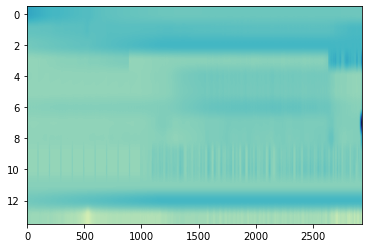

In [6]:
# Scalar features
plt.imshow(X[:,:14].T, cmap='YlGnBu', aspect='auto')

In [7]:
df = pd.DataFrame(X[:,:14], columns=col_names)
df

,q95,internal_inductance,plasma_current,locked_mode_amplitude,norm_beta,stored_energy,plasma_density,radiated_power_core,radiated_power_edge,input_power,input_beam_torque,plasma_current_direction,plasma_current_target,plasma_current_error
0,9.09705,3.998029,2.651291,0.125871,0.338027,0.129619,0.916954,0.243341,0.317592,1.196482,1.410511,1.0,2.570460,-0.014722
1,9.09705,3.998029,2.652814,0.111867,0.338027,0.129619,0.995484,0.243341,0.317592,0.000000,0.000000,1.0,2.573919,-0.040126
2,9.09705,3.993030,2.645228,0.009847,0.333054,0.127897,0.924176,0.243341,0.317592,0.000000,0.000000,1.0,2.576514,-0.165985
3,9.09705,3.978850,2.660321,0.098529,0.326178,0.125292,0.994838,0.243341,0.317592,0.000000,0.000000,1.0,2.579973,-0.024751
4,9.09705,4.047975,2.668117,0.174707,0.326464,0.125647,0.971530,0.243341,0.317592,0.000000,0.000000,1.0,2.583433,0.027176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2923,2.97086,6.140669,6.635368,7.624151,0.044957,0.041204,0.864710,28.101873,8.802933,2.670434,1.304350,1.0,6.603315,-2.194593
2924,2.97086,5.761318,6.911973,16.080912,0.002216,0.002047,2.115293,28.101873,8.802933,2.656228,1.327467,1.0,6.603315,1.202309
2925,2.97086,6.469927,7.242387,19.240700,4.709975,4.732166,6.759318,28.101873,8.802933,2.719174,1.283328,1.0,6.603315,5.260244
2926,2.97086,6.469927,6.326215,16.267811,4.709975,4.732166,5.382651,28.101873,8.802933,1.802221,1.955081,1.0,6.603315,-5.991445


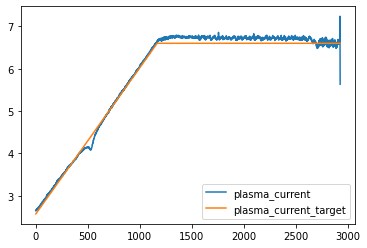

In [8]:
df[['plasma_current', 'plasma_current_target']].plot()

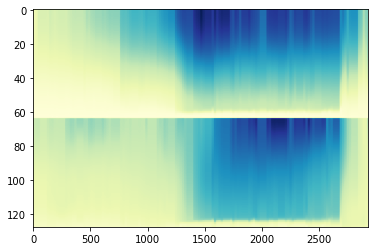

In [9]:
# Temperature profile and density profile
plt.imshow(X[:,14:].T, cmap='YlGnBu', aspect='auto')

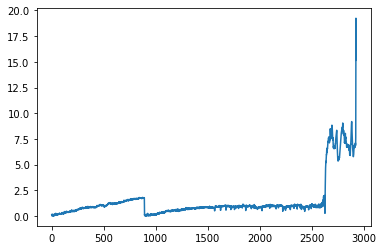

In [10]:
df.locked_mode_amplitude.plot()

In [11]:
from timecast.modules import PredictLast

In [12]:
pl = PredictLast(steps=30)
ts = jnp.array(df.locked_mode_amplitude)

pred = []
for x in tqdm(ts):
    pred.append(pl(x))

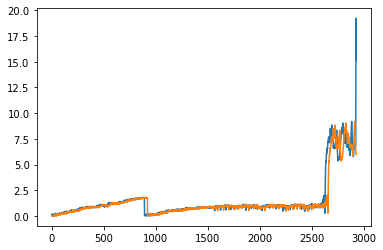

In [13]:
plt.plot(ts)
plt.plot(pred)

In [14]:
pl = PredictLast(steps=30)
ts = jnp.array(df.locked_mode_amplitude)

def loop(module, x):
    return module, module(x)

pl, results = jax.lax.scan(loop, pl, ts)

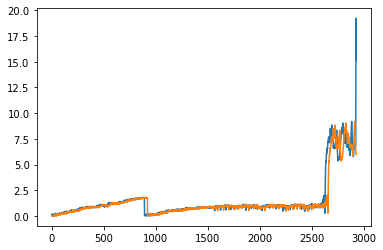

In [15]:
plt.plot(ts)
plt.plot(results)

In [16]:
MSE = lambda true, pred: jnp.square(jnp.asarray(true) - jnp.asarray(pred)).mean()

# Prepare data

In [17]:
path = "data/fusion/original"
if not os.path.exists(path):
    os.makedirs(path)

for shot in tqdm(list(shot_data.keys())):
    pickle.dump(shot_data[shot]["X"], open(f"{path}/{shot}.pkl", "wb"))

# PredictConstant

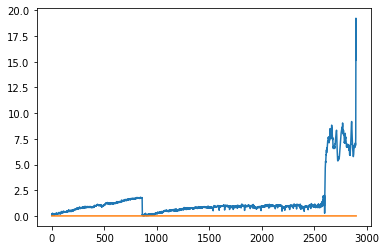

In [18]:
from timecast.modules import PredictConstant

pl = PredictConstant()
xs = jnp.array(df.locked_mode_amplitude)

ys = []
for x in tqdm(xs):
    ys.append(pl(x))
    
ts = xs[30:]
ys = ys[:-30]

plt.plot(ts)
plt.plot(ys)

In [4]:
@experiment("shot", test_keys)
def runner(shot):
    import jax
    import pickle
    import jax.numpy as jnp
    
    from timecast.modules import PredictConstant
    
    MSE = lambda true, pred: jnp.square(jnp.asarray(true) - jnp.asarray(pred)).mean()
    
    pc = PredictConstant()
    
    data = pickle.load(open(f"data/fusion/original/{shot}.pkl", "rb"))
    
    # Locked mode amplitude
    xs = data[:, 3]
    xs = data[:, 3]
    xs, ts = xs[:-30], xs[30:]
    
    def loop(module, xy):
        x, y = xy
        return module, module(x)
    
    ar, ys = jax.lax.scan(loop, pc, (xs, ts))
    
    return {
        "shot": shot,
        "mse": MSE(ts, ys)
    }

In [5]:
pc_results = runner.run(processes=50, tqdm=tqdm)

In [6]:
np.mean([shot["mse"] for shot in pc_results])

37.27233

# PredictLast

In [22]:
pl = PredictLast()
xs = jnp.array(df.locked_mode_amplitude)

In [23]:
ys = []
for x in tqdm(xs):
    ys.append(pl(x))

In [24]:
ts = xs[30:]
ys = ys[:-30]

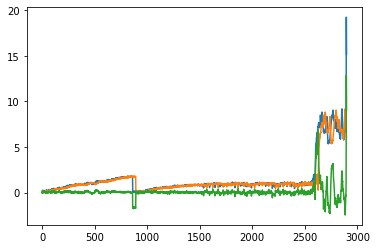

In [25]:
plt.plot(ts)
plt.plot(ys)
plt.plot(np.array(ts) - np.array(ys).squeeze())

In [26]:
MSE(ts, ys)

DeviceArray(7.575396, dtype=float32)

In [7]:
@experiment("shot", test_keys)
def runner(shot):
    import jax
    import pickle
    import jax.numpy as jnp
    
    from timecast.modules import PredictLast
    
    MSE = lambda true, pred: jnp.square(jnp.asarray(true) - jnp.asarray(pred)).mean()
    
    pl = PredictLast()
    
    data = pickle.load(open(f"data/fusion/original/{shot}.pkl", "rb"))
    
    # Locked mode amplitude
    xs = data[:, 3]
    xs, ts = xs[:-30], xs[30:]
    
    
    def loop(module, xy):
        x, y = xy
        return module, module(x)
    
    ar, ys = jax.lax.scan(loop, pl, (xs, ts))
    
    return {
        "shot": shot,
        "mse": MSE(ts, ys)
    }

In [8]:
pl_results = runner.run(processes=50, tqdm=tqdm)

In [9]:
np.mean([shot["mse"] for shot in pl_results])

18.568068

# AR

In [30]:
from typing import Iterable
from timecast.modules import AR, Linear
from timecast import Module
from timecast.optim import SGD

In [31]:
ar = AR(10, 1, 1)
xs = jnp.array(df.locked_mode_amplitude)

xs, ts = xs[:-30], xs[30:]

sgd = SGD()

def loop(module, xy):
    x, y = xy
    pred = module(x)
    module = sgd(module, x, y)
    
    return module, pred

ar, results = jax.lax.scan(loop, ar, (xs, ts))

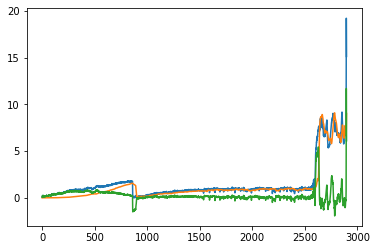

In [32]:
plt.plot(ts)
plt.plot(results)
plt.plot(np.array(ts) - np.array(results.squeeze()))

In [33]:
MSE(results, ts)

DeviceArray(7.914255, dtype=float32)

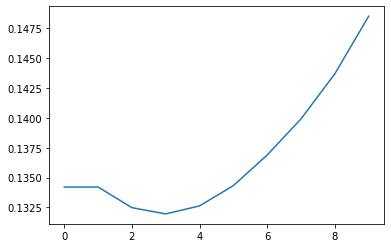

In [34]:
plt.plot(ar.linear.kernel.squeeze())

In [258]:
[df[col].mean() for col in df]

[851812829646.3374,
 inf,
 311.9806815073767,
 69.76177878029031,
 130.26593284769407,
 95.08721229743287]